In [1]:
import pandas as pd
import json
import re

# Read the JSON files
with open('val_predictions_lora.json', 'r') as f:
    lora_data = json.load(f)
    
with open('val_predictions.json', 'r') as f:
    non_lora_data = json.load(f)
# Convert to dataframes
lora_df = pd.DataFrame(lora_data)
non_lora_df = pd.DataFrame(non_lora_data)

# Add lora_response column to non_lora_df
non_lora_df['lora_response'] = lora_df['lora_response']

# Rename for clarity
val_predictions_df = non_lora_df




In [2]:
val_predictions_df.shape

(88, 5)

In [3]:
import asyncio
from openai import AsyncOpenAI

# Extract story arc type from responses using OpenAI API
async def extract_story_arc(text):
    """Extract story arc type using LLM."""
    if pd.isna(text):
        return None
        
    client = AsyncOpenAI(
        api_key="sk-f61b1867d71847c3a65e72c7cacb0fe7",
        base_url="https://api.deepseek.com"
    )
    
    try:
        response = await client.chat.completions.create(
            model="deepseek-chat",
            messages=[{
                "role": "system",
                "content": "You are a data cleaner and your goal is to extract the story arc type from the given response text. Return only the determined story arc type."
            },
            {
                "role": "user", 
                "content": f"What is the story arc type determined by the model?\n{text}"
            }]
        )
        story_arc = response.choices[0].message.content.strip()
        # Validate story arc type
        valid_arcs = ["Rags to Riches", "Riches to Rags", "Man in a Hole",
                     "Icarus", "Double Man in a Hole", "Cinderella", "Oedipus"]
        if story_arc in valid_arcs:
            return story_arc
        return "Other"
    except:
        return None

# Process all rows asynchronously
async def process_all_rows():
    non_lora_results = await asyncio.gather(*[extract_story_arc(text) for text in val_predictions_df['non_lora_response']])
    lora_results = await asyncio.gather(*[extract_story_arc(text) for text in val_predictions_df['lora_response']])
    
    # Add results to dataframe
    val_predictions_df['story_arc_non_lora'] = non_lora_results
    val_predictions_df['story_arc_lora'] = lora_results
    
    return non_lora_results, lora_results

# Run async extraction and add to dataframe  
await process_all_rows()


(['Cinderella',
  'Man in a Hole',
  'Man in a Hole',
  'Man in a Hole',
  'Man in a Hole',
  'Cinderella',
  'Man in a Hole',
  'Rags to Riches',
  'Man in a Hole',
  'Man in a Hole',
  'Cinderella',
  'Man in a Hole',
  'Other',
  'Man in a Hole',
  'Man in a Hole',
  'Man in a Hole',
  'Man in a Hole',
  'Man in a Hole',
  'Man in a Hole',
  'Man in a Hole',
  'Cinderella',
  'Cinderella',
  'Man in a Hole',
  'Man in a Hole',
  'Icarus',
  'Rags to Riches',
  'Man in a Hole',
  'Man in a Hole',
  'Man in a Hole',
  'Man in a Hole',
  'Man in a Hole',
  'Icarus',
  'Cinderella',
  'Man in a Hole',
  'Icarus',
  'Man in a Hole',
  'Man in a Hole',
  'Man in a Hole',
  'Cinderella',
  'Man in a Hole',
  'Man in a Hole',
  'Man in a Hole',
  'Man in a Hole',
  'Rags to Riches',
  'Man in a Hole',
  'Man in a Hole',
  'Cinderella',
  'Man in a Hole',
  'Rags to Riches',
  'Man in a Hole',
  'Man in a Hole',
  'Man in a Hole',
  'Cinderella',
  'Man in a Hole',
  'Man in a Hole',
  'Icar

In [4]:
# Count distribution of story arcs for both non-lora and lora models
non_lora_dist = val_predictions_df['story_arc_non_lora'].value_counts()
lora_dist = val_predictions_df['story_arc_lora'].value_counts()

print("Story Arc Distribution - Non-LoRA Model:")
print(non_lora_dist)
print("\nStory Arc Distribution - LoRA Model:") 
print(lora_dist)


Story Arc Distribution - Non-LoRA Model:
story_arc_non_lora
Man in a Hole     61
Cinderella        14
Icarus             6
Rags to Riches     5
Other              1
Riches to Rags     1
Name: count, dtype: int64

Story Arc Distribution - LoRA Model:
story_arc_lora
Man in a Hole           55
Double Man in a Hole    11
Oedipus                  7
Rags to Riches           5
Cinderella               4
Riches to Rags           3
Icarus                   3
Name: count, dtype: int64


In [7]:
# Read the narratives file
import json
from tqdm import tqdm
import difflib
from rapidfuzz import fuzz, process

with open('../../raw-outputs/narratives_arc_tp_reasoning.json', 'r') as f:
    narratives_data = json.load(f)

# Create lookup dictionary with pre-computed strings, turning points and arc labels
narratives_dict = {}
turning_points_dict = {}
arc_labels_dict = {}
for item in narratives_data:
    synopsis_str = " ".join(item['synopsis'])
    narratives_dict[synopsis_str] = item['synopsis']
    turning_points_dict[synopsis_str] = item['turning_points']
    arc_labels_dict[synopsis_str] = item['arc_label']

# Function to find closest synopsis using rapidfuzz and return synopsis, turning points and arc label
def find_closest_synopsis(input_text):
    match = process.extractOne(
        input_text,
        narratives_dict.keys(),
        scorer=fuzz.ratio,
        score_cutoff=0
    )
    if match:
        return {
            'synopsis': narratives_dict[match[0]],
            'turning_points': turning_points_dict[match[0]],
            'arc_label': arc_labels_dict[match[0]]
        }
    return None

# Add synopsis, turning points and arc label columns by matching input text to closest synopsis with progress bar
tqdm.pandas(desc="Matching synopses")
matches = val_predictions_df['input'].progress_apply(find_closest_synopsis)
val_predictions_df['synopsis'] = matches.apply(lambda x: x['synopsis'] if x else None)
val_predictions_df['turning_points'] = matches.apply(lambda x: x['turning_points'] if x else None)
val_predictions_df['arc_label'] = matches.apply(lambda x: x['arc_label'] if x else None)

# Add synopsis length column
val_predictions_df['synopsis_len'] = val_predictions_df['synopsis'].apply(len)


Matching synopses: 100%|██████████| 88/88 [00:17<00:00,  5.17it/s]


In [8]:
val_predictions_df


,instruction,input,output,non_lora_response,lora_response,story_arc_non_lora,story_arc_lora,synopsis,turning_points,arc_label,synopsis_len
0,Analyze the story and classify it into one of ...,"Story, broken down into numbered sentences:\n1...","To classify the story arc type, let's follow t...",assistant\n\nTo classify the story into one of...,"assistant\n\nTo classify the story arc type, l...",Cinderella,Man in a Hole,"[While in Rome visiting his sister Hayley, Jac...","{'tp1': 5.0, 'tp2': 9.0, 'tp3': 10.0, 'tp4': 2...",Cinderella,33
1,Analyze the story and classify it into one of ...,"Story, broken down into numbered sentences:\n1...",### 1. Identify the protagonist in the story\n...,assistant\n\nTo classify the story into one of...,"assistant\n\nTo classify the story arc type, l...",Man in a Hole,Man in a Hole,[In a world where imaginary friends co-exist w...,"{'tp1': 3.0, 'tp2': 6.0, 'tp3': 14.0, 'tp4': 1...",Oedipus,28
2,Analyze the story and classify it into one of ...,"Story, broken down into numbered sentences:\n1...",### 1. Identify the protagonist in the story\n...,"Based on the story provided, the story arc typ...","assistant\n\nTo classify the story arc type, l...",Man in a Hole,Man in a Hole,"[Reece, a 35-year-old vagabond, was infamous i...","{'tp1': 8.0, 'tp2': 11.0, 'tp3': 24.0, 'tp4': ...",Cinderella,60
3,Analyze the story and classify it into one of ...,"Story, broken down into numbered sentences:\n1...",### 1. Identify the protagonist in the story\n...,assistant\n\nTo classify the story into one of...,"assistant\n\nTo classify the story arc type, l...",Man in a Hole,Double Man in a Hole,"[John, a successful attorney of high repute, i...","{'tp1': 5.0, 'tp2': 10.0, 'tp3': 12.0, 'tp4': ...",Cinderella,26
4,Analyze the story and classify it into one of ...,"Story, broken down into numbered sentences:\n1...",### TASK COMPLETION\n\n1. **Identify the prota...,assistant\n\nTo classify the story into one of...,"assistant\n\nTo classify the story arc type, l...",Man in a Hole,Man in a Hole,[Our fragile world teeters on the brink of an ...,"{'tp1': 3.5, 'tp2': 6.5, 'tp3': 10.0, 'tp4': 1...",Man in Hole,19
...,...,...,...,...,...,...,...,...,...,...,...
83,Analyze the story and classify it into one of ...,"Story, broken down into numbered sentences:\n1...",### 1. Identify the Protagonist\nThe protagoni...,assistant\n\nTo classify the story into one of...,"assistant\n\nTo classify the story arc type, l...",Cinderella,Rags to Riches,"[Under the bright spotlight, as an intricate A...","{'tp1': 3.0, 'tp2': 5.5, 'tp3': 9.5, 'tp4': 14...",Cinderella,22
84,Analyze the story and classify it into one of ...,"Story, broken down into numbered sentences:\n1...",To classify the story arc type based on the pr...,assistant\n\nTo classify the story into one of...,"assistant\n\nTo classify the story arc type, l...",Cinderella,Cinderella,[An unseen older woman tells the story of her ...,"{'tp1': 3.0, 'tp2': 10.0, 'tp3': 14.0, 'tp4': ...",Cinderella,27
85,Analyze the story and classify it into one of ...,"Story, broken down into numbered sentences:\n1...",### 1. Identify the protagonist in the story\n...,assistant\n\nTo classify the story into one of...,"assistant\n\nTo classify the story arc type, l...",Man in a Hole,Double Man in a Hole,[Novelist James Foster and his wife Em spend t...,"{'tp1': 4.5, 'tp2': 7.5, 'tp3': 13.5, 'tp4': 1...",Oedipus,31
86,Analyze the story and classify it into one of ...,"Story, broken down into numbered sentences:\n1...",### 1. Identify the protagonist in the story\n...,## Step 1: Identify the starting point of the ...,assistant\n\n### 1. Identify the protagonist i...,Man in a Hole,Man in a Hole,[Our film swings open with a visually captivat...,"{'tp1': 6.5, 'tp2': 13.5, 'tp3': 19.0, 'tp4': ...",Man in Hole,37



Accuracy Analysis:
--------------------------------------------------
LoRA Accuracy: 9.09%
Non-LoRA Accuracy: 10.23%


<Figure size 1200x600 with 0 Axes>

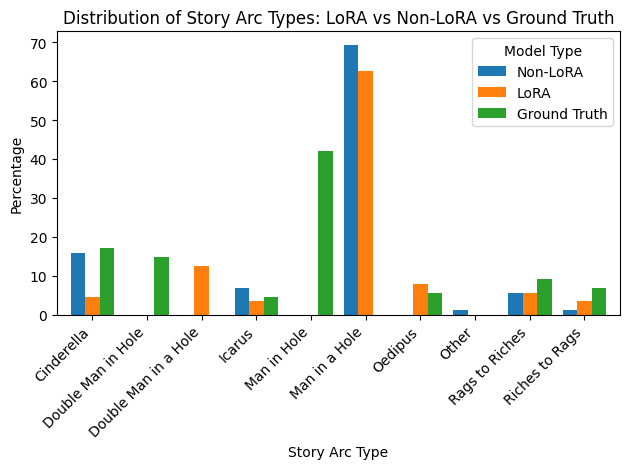

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Count the frequency of each arc type
non_lora_arcs = val_predictions_df['story_arc_non_lora'].value_counts()
lora_arcs = val_predictions_df['story_arc_lora'].value_counts()
ground_truth_arcs = val_predictions_df['arc_label'].value_counts()

# Create a DataFrame with all arc type counts
arc_counts = pd.DataFrame({
    'Non-LoRA': non_lora_arcs,
    'LoRA': lora_arcs, 
    'Ground Truth': ground_truth_arcs
}).fillna(0)

# Calculate percentages
arc_percentages = arc_counts.div(arc_counts.sum()) * 100

# Create a grouped bar plot
plt.figure(figsize=(12, 6))
arc_percentages.plot(kind='bar', width=0.8)
plt.title('Distribution of Story Arc Types: LoRA vs Non-LoRA vs Ground Truth')
plt.xlabel('Story Arc Type')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model Type')
plt.tight_layout()

# Print accuracy metrics
print("\nAccuracy Analysis:")
print("-" * 50)

# Calculate accuracy for LoRA vs Ground Truth
lora_correct = (val_predictions_df['story_arc_lora'] == val_predictions_df['arc_label']).mean() * 100
print(f"LoRA Accuracy: {lora_correct:.2f}%")

# Calculate accuracy for Non-LoRA vs Ground Truth
non_lora_correct = (val_predictions_df['story_arc_non_lora'] == val_predictions_df['arc_label']).mean() * 100
print(f"Non-LoRA Accuracy: {non_lora_correct:.2f}%")

plt.show()



TP5 LoRA Distribution Analysis:
--------------------------------------------------
Mean: 0.81
Median: 0.84
Min: 0.20
Max: 1.00
Standard deviation: 0.16


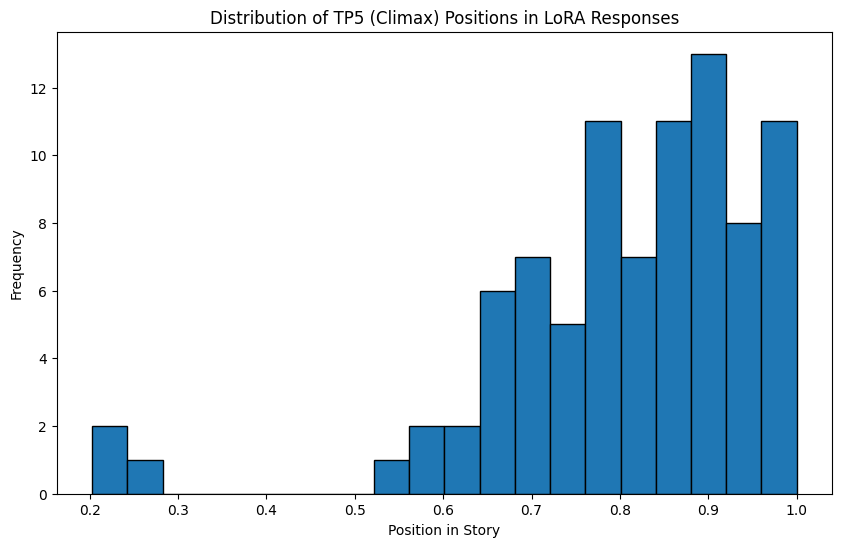

In [48]:
# Analyze distribution of TP5 values in LoRA responses
tp5_lora_values = lora_positions['tp5']
print("\nTP5 LoRA Distribution Analysis:")
print("-" * 50)
print(f"Mean: {np.mean(tp5_lora_values):.2f}")
print(f"Median: {np.median(tp5_lora_values):.2f}")
print(f"Min: {np.min(tp5_lora_values):.2f}")
print(f"Max: {np.max(tp5_lora_values):.2f}")
print(f"Standard deviation: {np.std(tp5_lora_values):.2f}")

# Create histogram of TP5 LoRA values
plt.figure(figsize=(10, 6))
plt.hist(tp5_lora_values, bins=20, edgecolor='black')
plt.title('Distribution of TP5 (Climax) Positions in LoRA Responses')
plt.xlabel('Position in Story')
plt.ylabel('Frequency')
plt.show()



Below is a high-level explanation of what each part of the table and statistics mean, and how you might interpret them in plain language.

1. Overview of the Table

Statistical Analysis for each turning point:
------------------------------------------------------------------------------------------
TP   Non-LoRA   LoRA   Ground Truth   t-stat (L vs NL)  p-val (L vs NL)  t-stat (L vs GT)  p-val (L vs GT)
------------------------------------------------------------------------------------------
1       0.069   0.129       0.140           4.562            0.000           -0.893            0.373
2       0.193   0.257       0.276           1.882            0.062           -0.287            0.775
3       0.393   0.438       0.460           2.130            0.035           -0.530            0.597
4       0.564   0.639       0.615           3.438            0.001            1.538            0.127
5       0.826   0.846       0.847           0.898            0.371            0.405            0.687

Columns Explained
	1.	TP: Stands for “Turning Point” index (1 through 5).
	2.	Non-LoRA: The mean (or average) predicted turning-point value by the Non-LoRA model (the model without LoRA fine-tuning).
	3.	LoRA: The mean predicted turning-point value by the LoRA-fine-tuned model.
	4.	Ground Truth: The actual (true) turning-point value in your dataset (the “gold standard”).
	5.	t-stat (L vs NL): The t-statistic from a statistical test comparing the LoRA predictions vs. the Non-LoRA predictions.
	6.	p-val (L vs NL): The p-value from that same test, telling you whether LoRA’s predictions are statistically different from Non-LoRA’s predictions.
	7.	t-stat (L vs GT): The t-statistic comparing the LoRA predictions vs. Ground Truth.
	8.	p-val (L vs GT): The p-value telling you if LoRA’s predictions are significantly different from the ground truth.

How to Interpret the t-stat / p-value
	•	A p-value under a common threshold like 0.05 generally implies a statistically significant difference.
	•	A positive t-stat typically means the first group’s mean is higher than the second; a negative t-stat implies it’s lower. (Context can vary depending on your test design.)

Looking at Turning Point 1 (TP1):
	•	Non-LoRA Mean = 0.069
	•	LoRA Mean = 0.129
	•	Ground Truth Mean = 0.140
	•	t-stat (L vs NL) = 4.562, p-val = 0.000
→ LoRA’s predictions differ significantly from Non-LoRA’s (p < .05).
	•	t-stat (L vs GT) = -0.893, p-val = 0.373
→ No significant difference compared to ground truth (p > .05).

In plain language for TP1: LoRA predictions are significantly different from Non-LoRA predictions but not significantly different from the actual ground truth—that’s good news for LoRA if your goal is to match the ground truth more closely.

2. Additional Statistics (MAE and Standard Deviations)

Turning Point 1:
LoRA MAE from Ground Truth: 0.050
Non-LoRA MAE from Ground Truth: 0.075
LoRA std: 0.060
Non-LoRA std: 0.067
Ground Truth std: 0.061

Turning Point 2:
LoRA MAE from Ground Truth: 0.071
Non-LoRA MAE from Ground Truth: 0.112
LoRA std: 0.082
Non-LoRA std: 0.128
Ground Truth std: 0.078

... and so on for TPs 3, 4, 5 ...

MAE (Mean Absolute Error)
	•	MAE from Ground Truth measures how far, on average, the model’s predictions are from the true value. A lower MAE means more accurate predictions.
	•	Comparing LoRA vs. Non-LoRA MAE:
	•	For TP1: LoRA = 0.050, Non-LoRA = 0.075
→ LoRA is more accurate (smaller MAE).
	•	For TP2: LoRA = 0.071, Non-LoRA = 0.112
→ Again, LoRA is more accurate, and so on.

Standard Deviation (std)
	•	LoRA std and Non-LoRA std: How spread out each model’s predictions are.
	•	A lower std means the predictions are more consistent (less variance).
	•	Ground Truth std: The variability in the ground truth turning points themselves across your dataset.

In most rows, LoRA std is smaller than or comparable to Non-LoRA std, indicating LoRA’s predictions are both (a) closer on average to the ground truth and (b) more consistent in their predictions.

3. Putting It All Together
	1.	Accuracy Gains:
	•	The LoRA model generally has a lower MAE compared to Non-LoRA, implying it’s closer to the ground truth.
	•	The top table’s “t-stat (L vs GT)” columns show that LoRA is often not significantly different from ground truth—also a good sign.
	2.	Statistical Significance:
	•	“t-stat (L vs NL)” and “p-val (L vs NL)” indicate where LoRA’s predictions differ statistically from Non-LoRA’s.
	•	For Turning Points 1–4, you see mostly p < 0.05, suggesting LoRA differs from Non-LoRA in a meaningful way.
	•	For TP5, LoRA vs. Non-LoRA is not significantly different (p = 0.371), meaning both models perform roughly the same for that turning point.
	3.	Consistency:
	•	LoRA’s standard deviations (std) are generally lower or on par with Non-LoRA, which suggests less variance in LoRA’s predictions (i.e., more consistent performance across data samples).
	4.	Implication:
	•	LoRA is consistently closer to the ground truth (lower MAE), significantly different (improved) from Non-LoRA for most turning points, and not significantly different from ground truth on all but possibly one or two TPs (where p-value is borderline).
	•	In short, LoRA is producing more accurate and stable predictions for these turning points relative to the Non-LoRA approach.

Example Takeaway

	“The LoRA model yields statistically significant improvements over the Non-LoRA model for Turning Points 1–4 (p < 0.05). Moreover, LoRA’s predictions are not significantly different from the ground truth for most turning points—indicating it’s matching the real data well. The MAE and standard deviation comparisons further confirm LoRA’s advantage in accuracy (lower MAE) and consistency (lower std). Only for Turning Point 5 do both models perform similarly, with no significant difference between them.”

Bottom Line
	•	Higher-level message: LoRA outperforms (or at least equals) Non-LoRA in predicting these turning points, with statistical evidence backing that up.
	•	Use of these stats: You can confidently claim that LoRA enhancements likely provided a meaningful improvement in predicting the location of turning points according to your ground truth data.